In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.8 MB/s eta 0:00:00


In [5]:

#Comparison Between CNN and SVM with their application of the Fashion MNIST Dataset

#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report





In [6]:
#Path for the datasets
train_path ='/content/drive/MyDrive/neural_computing_coursework/fashion-mnist_train.csv'
test_path = '/content/drive/MyDrive/neural_computing_coursework/fashion-mnist_test.csv'
#loading of the datasets into dataframe
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [7]:
#Shape of the loaded training dataset
print(train_data.shape)

#Shape of the loaded training dataset
print(test_data.shape)


(60000, 785)
(10000, 785)


In [8]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


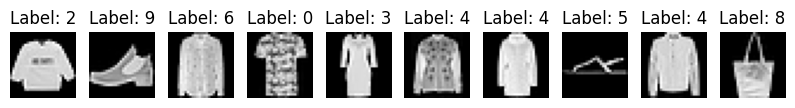

In [10]:
#The display_images function provides a visualization of 10 images from the training dataset
#and creates horizontal sub-plots with each image with its respective label.
#the function reshapes the image from its falttened form and displays it using grayscale colormap

def display_images(data, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        img = data.iloc[i, 1:].values.reshape(28, 28)
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {data.iloc[i, 0]}')
    plt.show()

display_images(train_data)



In [11]:
#This code computes the frequency of the occurence of the labels from training dataset
#and sorts them by the index value
label_counts = train_data['label'].value_counts().sort_index()
print("Counts of labels in the Training Dataset:")
print(label_counts)


Counts of labels in the Training Dataset:
label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [12]:
#This code creates a dictionary of labels and their corresponding class names and prints them.
#this is essential for mapping of the between lables and classes.
label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
print("Lables with theri classes:")
for label, name in label_names.items():
    print(f"{label}: {name}")


Lables with theri classes:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [13]:
#training and test data is split and converted into numpy array for machine learing
X_train = train_data.drop('label', axis=1).values.astype(np.float32)
y_train = train_data['label'].values.astype(np.int64)
X_test = test_data.drop('label', axis=1).values.astype(np.float32)
y_test = test_data['label'].values.astype(np.int64)

In [14]:
#Scaling the pixel value to [0,1] range to bring all inputs on similar scale
X_train /= 255.0
X_test /= 255.0

Original Images:


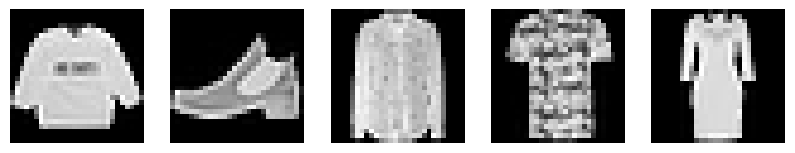

Flipped Images:


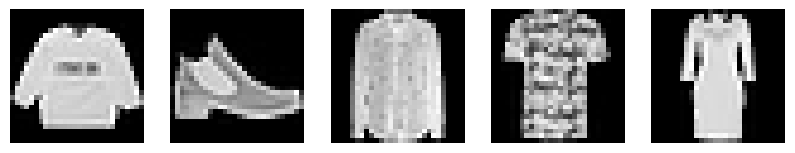

Original Images:


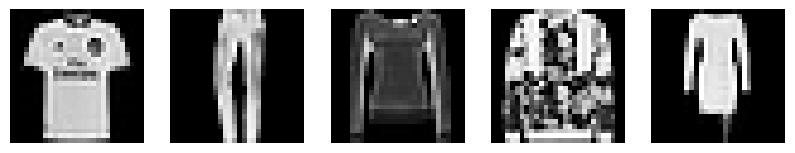

Flipped Images:


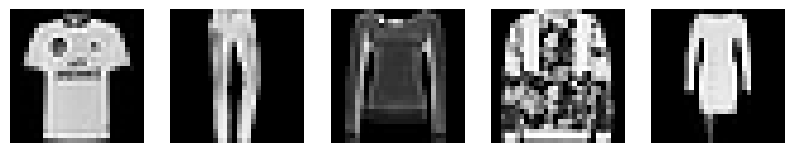

In [15]:
#Images are flipped horrizontally from left to right to increase robustness of the trained models

X_train_flipped = np.array([np.fliplr(img.reshape(28, 28)).flatten() for img in X_train])
X_test_flipped = np.array([np.fliplr(img.reshape(28, 28)).flatten() for img in X_test])

#This code displays the original and flipped images
def display_images(images, number_of_images=5):
    fig, axes = plt.subplots(1, number_of_images, figsize=(10, 2))
    for i in range(number_of_images):
        ax = axes[i]
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

print("Original Images:")
display_images(X_train)

print("Flipped Images:")
display_images(X_train_flipped)

print("Original Images:")
display_images(X_test)

print("Flipped Images:")
display_images(X_test_flipped)

In [16]:
#This code reshapes the flipped training and test datasets into 4D arrays for using in CNN
#labels however are extracted from the original data
#the features data from training and test dataset are further normalized
X_train_flipped = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype('float32')
y_train = train_data.iloc[:, 0].values
X_test_flipped = test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype('float32')
y_test = test_data.iloc[:, 0].values

X_train_flipped /= 255.0
X_test_flipped /= 255.0


In [17]:
#Implementation of CNN with 2 convolution layers with max pooling and 2 fully connected layers. Dropout is applied to the first fully connected
#layer for regularlisation and preventing overfitting
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
#Neural Network classifier is implemented with max '10' iterations along with Stochastic Gradient Descent optimizer and CrossEntropy loss since we have a
#multi-class classification task
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=SGD,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'  # This determines the utilisation of either 'GPU' or 'CPU'.
)


In [19]:
#The model is fit with training data and corresponding labels for training
net.fit(X_train_flipped, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5462       0.6929        0.8646  3.7401
      2        0.8193       0.7408        0.7024  2.3564
      3        0.7157       0.7645        0.6313  2.3271
      4        0.6590       0.7823        0.5803  2.3041
      5        0.6119       0.8017        0.5414  2.2735
      6        0.5777       0.8107        0.5162  2.3280
      7        0.5488       0.8217        0.4921  2.5399
      8        0.5262       0.8331        0.4611  2.6877
      9        0.5043       0.8383        0.4454  2.3060
     10        0.4881       0.8416        0.4332  2.2757


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=1024, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  ),
)

In [20]:

# Save the trained CNN base model
joblib.dump(net, 'trained_cnn_base_model.pkl')

['trained_cnn_base_model.pkl']

In [21]:
# Performing predictions on the trained model
y_pred_train = net.predict(X_train_flipped)
#calculating the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy of the CNN model: {train_accuracy * 100:.2f}%")




Training Accuracy of the CNN model: 84.43%


In [22]:
#CNN with hyper paramater optimisation

In [23]:
#CNN is implmented with number of filters in each of its layers and dropout rates making it more adaptable.
#padding is also implemented to prevent the information loss at the border of images
class CNN(nn.Module):
    def __init__(self, num_filters_1=32, num_filters_2=64, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(1, num_filters_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, kernel_size=5, padding=2)

        #This line ensures that the input size of the fully connected layer matches with the size of the feautered maps.
        self.fc1 = nn.Linear(num_filters_2 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, self.num_filters_2 * 7 * 7)  # Ensure the feature map size matches this calculation
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
#Neural Network classifier is implemented with Stochastic Gradient Descent optimizer and CrossEntropy loss since we have a
#multi-class classification task
cnn_model_architecture = NeuralNetClassifier(
    module=CNN,
    module__num_filters_1=32,
    module__num_filters_2=64,
    module__dropout_rate=0.5,
    max_epochs=10,
    lr=0.01,
    batch_size=64,
    optimizer=torch.optim.SGD,
    criterion=nn.CrossEntropyLoss,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [25]:
#certain parameters are repeated to maintain consistency between the defined neural architecture and grid search.
#Grid Search will override the values in the classifier with that from the grid_hyper_parameters
#while still adhering to the constraints set by the Classifier.
grid_hyper_parameters = {
    'lr': [0.1,0.01],
    'module__num_filters_1': [32, 64],
    'module__num_filters_2': [64, 128],
    'module__dropout_rate': [0.25, 0.5],
    'max_epochs': [10,20]
}
trained_model = GridSearchCV(cnn_model_architecture, grid_hyper_parameters, refit=True, cv=2, scoring='accuracy', verbose=2)

In [26]:
#model is trained with the parameters. the final model is trained using the best hyperparameters obtained
trained_model.fit(X_train_flipped, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8841       0.7707        0.6059  1.4248
      2        0.5090       0.8475        0.4217  1.3291
      3        0.4235       0.8695        0.3668  1.3822
      4        0.3751       0.8748        0.3444  1.3904
      5        0.3449       0.8822        0.3307  1.3188
      6        0.3139       0.8860        0.3162  1.3241
      7        0.2942       0.8853        0.3054  1.3195
      8        0.2735       0.8878        0.3016  1.3155
      9        0.2577       0.8920        0.2851  1.3473
     10        0.2439       0.8950        0.2800  1.3220
[CV] END lr=0.1, max_epochs=10, module__dropout_rate=0.25, module__num_filters_1=32, module__num_filters_2=64; total time=  14.4s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1    

GridSearchCV(cv=2,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.CNN'>,
  module__dropout_rate=0.5,
  module__num_filters_1=32,
  module__num_filters_2=64,
),
             param_grid={'lr': [0.1, 0.01], 'max_epochs': [10, 20],
                         'module__dropout_rate': [0.25, 0.5],
                         'module__num_filters_1': [32, 64],
                         'module__num_filters_2': [64, 128]},
             scoring='accuracy', verbose=2)

In [27]:
# Save the trained CNN hyper model model
joblib.dump(trained_model, 'trained_cnn_hyper_model.pkl')

['trained_cnn_hyper_model.pkl']

In [28]:
#This prints the best parameters found during training along with the mean and standard deviation scores for the hyperparameters
print("Best parameters set found during training:")
print(trained_model.best_params_)
print("Grid scores while training:")
means = trained_model.cv_results_['mean_test_score']
stds = trained_model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, trained_model.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.3f}) for {params}")

Best parameters set found during training:
{'lr': 0.1, 'max_epochs': 20, 'module__dropout_rate': 0.25, 'module__num_filters_1': 32, 'module__num_filters_2': 64}
Grid scores while training:
0.866 (+/-0.059) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.25, 'module__num_filters_1': 32, 'module__num_filters_2': 64}
0.867 (+/-0.047) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.25, 'module__num_filters_1': 32, 'module__num_filters_2': 128}
0.864 (+/-0.061) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.25, 'module__num_filters_1': 64, 'module__num_filters_2': 64}
0.873 (+/-0.053) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.25, 'module__num_filters_1': 64, 'module__num_filters_2': 128}
0.875 (+/-0.038) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'module__num_filters_1': 32, 'module__num_filters_2': 64}
0.873 (+/-0.044) for {'lr': 0.1, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'module__num_filters_1': 32, 'modul

In [29]:
#Printing the best accuracy obtained during cross validation
print("Best cross-validation accuracy: {:.2f}%".format(trained_model.best_score_ * 100))



Best cross-validation accuracy: 89.21%


In [30]:
#MLP Implementation

In [31]:
#features and labels from the training and test datasets are separeted nd normalised
X_train = train_data.iloc[:, 1:].values.astype('float32') / 255.0
y_train = train_data.iloc[:, 0].values.astype('int64')
X_test = test_data.iloc[:, 1:].values.astype('float32') / 255.0
y_test = test_data.iloc[:, 0].values.astype('int64')

In [32]:
#Multi layer perceptron of 3 hidden layers with ReLU activation is implemented.
#it returns output of size 10 which corresponds to the 10 output features of the dataset.
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.fc4 = nn.Linear(128, 10)   # Output layer
        self.relu = nn.ReLU()

#forward pass is implemented to define the sequence of operations
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [33]:
#NeuralNetClassifier is defined encapsulating the MLP architecture along with training parameters and optimization.
# L2 regularisation for the optimiser is implemeented to prevent overfitting.
MLP_model = NeuralNetClassifier(
    MLP,
    max_epochs=20,
    lr=0.1,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__weight_decay=1e-4,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [34]:
# The model is fit for training
MLP_model.fit(X_train, y_train)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7118       0.7807        0.5848  2.0055
      2        0.5077       0.8197        0.4928  1.9865
      3        0.4483       0.8373        0.4530  1.9392
      4        0.4211       0.8165        0.4921  1.9032
      5        0.3999       0.8304        0.4477  1.9295
      6        0.3848       0.8347        0.4319  1.9155
      7        0.3744       0.8496        0.4256  1.9546
      8        0.3734       0.8392        0.4280  1.9677
      9        0.3654       0.8447        0.4120  1.9548
     10        0.3639       0.8454        0.4017  1.9442
     11        0.3486       0.8486        0.4232  1.8918
     12        0.3474       0.8568        0.4107  1.9396
     13        0.3433       0.8563        0.4171  1.9284
     14        0.3354       0.8578        0.4075  1.9592
     15        0.3370       0.8562        0.4122  1.9026
     16        0.3325       0.8

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
    (relu): ReLU()
  ),
)

In [35]:
# Save the trained mlp base model
joblib.dump(MLP_model, 'trained_mlp_base_model.pkl')

['trained_mlp_base_model.pkl']

In [36]:
#MLP with hyperparameter optimisation

In [37]:
#Multilayer perceptron is defined with 4 fully connected layers with ReLU activation.
#the output layer produces 10 units output representing the 10 classes of the dataset.
#This model is created with Dropout regularisation to prevent overfiting and encourage robustness.
class MLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [38]:
#MLP based neural classifier is configured with all its parameters
hyper_MLP_model = NeuralNetClassifier(
    MLP,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    iterator_train__shuffle=True
)

#hyperparameters for grid search implmentation is defined
hyper_parameters = {
    'max_epochs': [10, 20],
    'lr': [0.01, 0.05, 0.1],
    'optimizer__momentum': [0.7, 0.9],
    'optimizer__weight_decay': [1e-4, 1e-3],
    'module__dropout_rate': [0.5, 0.6]
}

MLP_hyper_model = GridSearchCV(hyper_MLP_model, hyper_parameters, refit=True, cv=3, scoring='accuracy', verbose=2)

In [39]:
#the model is fitted and trained
MLP_hyper_model.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0813       0.5546        1.4385  0.8201
      2        1.2780       0.6252        0.9193  0.8433
      3        0.9712       0.6917        0.7687  0.8288
      4        0.8596       0.7239        0.7132  0.8311
      5        0.7964       0.7228        0.6724  0.8288
      6        0.7448       0.7622        0.6264  0.8285
      7        0.7015       0.7720        0.5880  0.8318
      8        0.6650       0.7870        0.5618  0.8370
      9        0.6322       0.7951        0.5380  0.8294
     10        0.6036       0.8119        0.5157  0.8390
[CV] END lr=0.01, max_epochs=10, module__dropout_rate=0.5, optimizer__momentum=0.7, optimizer__weight_decay=0.0001; total time=   8.8s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
     

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLP'>,
),
             param_grid={'lr': [0.01, 0.05, 0.1], 'max_epochs': [10, 20],
                         'module__dropout_rate': [0.5, 0.6],
                         'optimizer__momentum': [0.7, 0.9],
                         'optimizer__weight_decay': [0.0001, 0.001]},
             scoring='accuracy', verbose=2)

In [40]:
# Save the trained mlp hyperparameter model
joblib.dump(MLP_hyper_model, 'trained_mlp_hyper_model.pkl')

['trained_mlp_hyper_model.pkl']

In [41]:
# This will print all the Grid Scores obtained during model training
print("Grid scores obtained during model development: \n")
means = MLP_hyper_model.cv_results_['mean_test_score']
stds = MLP_hyper_model.cv_results_['std_test_score']
params = MLP_hyper_model.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean:.3f} (+/-{std * 2:.3f}) for {param}")

# Printing the best parameters and best score obtained during training
print("\nBest parameters obtained during training:", MLP_hyper_model.best_params_)
print("\nBest score during training: {:.2f}%".format(MLP_hyper_model.best_score_ * 100))

Grid scores obtained during model development: 

0.820 (+/-0.003) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'optimizer__momentum': 0.7, 'optimizer__weight_decay': 0.0001}
0.817 (+/-0.004) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'optimizer__momentum': 0.7, 'optimizer__weight_decay': 0.001}
0.856 (+/-0.006) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.0001}
0.855 (+/-0.007) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.5, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.001}
0.803 (+/-0.010) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.6, 'optimizer__momentum': 0.7, 'optimizer__weight_decay': 0.0001}
0.789 (+/-0.011) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.6, 'optimizer__momentum': 0.7, 'optimizer__weight_decay': 0.001}
0.846 (+/-0.008) for {'lr': 0.01, 'max_epochs': 10, 'module__dropout_rate': 0.6, 'optimize